# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [164]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [214]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/31-01-2022/1200/1200/first"
wantedCSVfilename = "data-batch-vs-acc-1200-1200.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [166]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [167]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [206]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [201]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [202]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [203]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
#     ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
#     ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [221]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #datasets = ['elecNormNew', 'GMSC', 'covtypeNorm']

    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'covtypeNorm': 'covtypeNorm', 'airlines': 'Airlines'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [222]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

**show charts**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


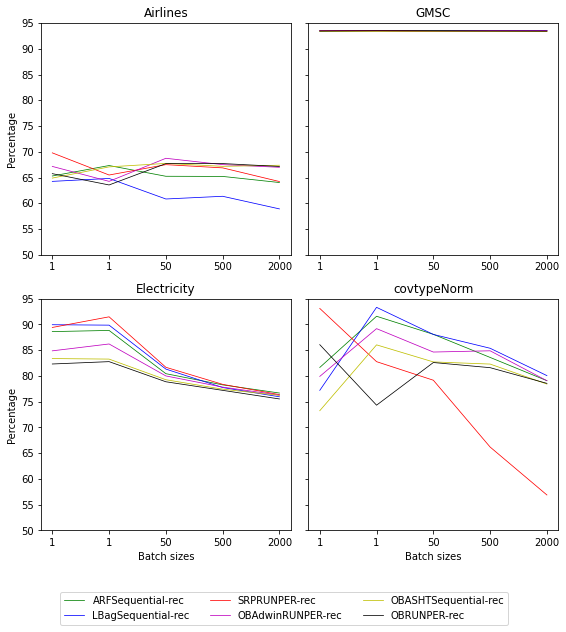

In [223]:
#false makes the chart without markers
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


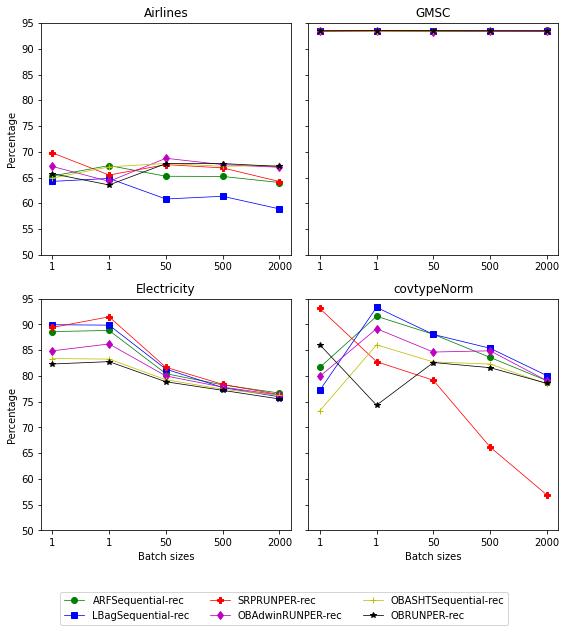

In [224]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
32,airlines,ARFSequential,25,1,1,125.844002,65.298329,63.478960,60.634973
118,airlines,ARFRUNPER,25,1,1,1359.349976,67.328862,63.892926,62.127677
41,airlines,ARFMB,25,50,1,121.334000,65.244318,65.077362,64.266123
55,airlines,ARFMB,25,500,1,121.185997,65.215385,64.342192,63.521649
40,airlines,ARFMB,25,2000,1,122.339996,64.030000,62.952923,62.222892


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
7,airlines,LBagSequential,25,1,1,127.165001,64.254237,57.996836,55.460027
22,airlines,LBagRUNPER,25,1,1,1600.744019,64.824715,61.004942,58.991331
48,airlines,LBagMB,25,50,1,120.053001,60.834254,60.185239,59.483744
57,airlines,LBagMB,25,500,1,120.358002,61.360000,59.945976,59.136039
90,airlines,LBagMB,25,2000,1,120.384003,58.910000,57.115502,56.274775


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
116,airlines,SRPRUNPER,25,1,1,993.926025,69.788696,65.955244,61.115220
113,airlines,SRPSequential,25,1,1,123.987000,65.489510,64.017149,60.513602
46,airlines,SRPMB,25,50,1,120.176003,67.501176,66.488220,64.893252
16,airlines,SRPMB,25,500,1,121.607002,66.875556,65.607525,63.884075
102,airlines,SRPMB,25,2000,1,124.224998,64.222222,63.661720,62.968792


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
88,airlines,OBAdwinRUNPER,25,1,1,1019.429993,67.157645,64.435790,61.663140
85,airlines,OBAdwinSequential,25,1,1,126.156998,64.257196,62.723714,61.522742
59,airlines,OBAdwinMB,25,50,1,120.202003,68.735883,65.515222,60.171254
44,airlines,OBAdwinMB,25,500,1,121.524002,67.505556,63.532882,60.518547
119,airlines,OBAdwinMB,25,2000,1,120.070000,66.988889,61.933265,59.621671


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
103,airlines,OBASHTSequential,25,1,1,126.403999,64.892857,63.282012,61.711999
66,airlines,OBASHTRUNPER,25,1,1,558.072021,67.066534,66.303717,62.595994
107,airlines,OBASHTMB,25,50,1,120.008003,67.740056,63.853562,60.449457
101,airlines,OBASHTMB,25,500,1,120.207001,67.175000,63.586115,60.269353
33,airlines,OBASHTMB,25,2000,1,120.870003,67.383990,63.276516,59.976549


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,airlines,OBRUNPER,25,1,1,347.303986,65.749586,64.763583,61.710739
86,airlines,OBSequential,25,1,1,127.524002,63.557294,61.858851,60.579783
3,airlines,OBMB,25,50,1,120.014000,67.699534,62.654347,60.004149
91,airlines,OBMB,25,500,1,120.021004,67.709353,62.657540,60.000800
76,airlines,OBMB,25,2000,1,120.088997,67.152239,62.152469,59.746809


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
56,GMSC,ARFSequential,25,1,1,122.223000,93.410020,74.905991,53.497763
14,GMSC,ARFRUNPER,25,1,1,219.264008,93.522000,76.935435,54.402225
23,GMSC,ARFMB,25,50,1,119.497002,93.524508,76.339238,54.970137
28,GMSC,ARFMB,25,500,1,118.941002,93.527759,76.958239,54.590860
19,GMSC,ARFMB,25,2000,1,122.472000,93.544531,76.767898,54.580865


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
77,GMSC,LBagRUNPER,25,1,1,176.445007,93.542000,76.361278,55.403724
35,GMSC,LBagSequential,25,1,1,121.859001,93.492900,74.876225,54.237668
106,GMSC,LBagMB,25,50,1,111.016998,93.442481,75.053047,53.985951
71,GMSC,LBagMB,25,500,1,91.057999,93.513043,77.084532,54.174428
109,GMSC,LBagMB,25,2000,1,89.663002,93.504054,76.114798,54.977835


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
5,GMSC,SRPSequential,25,1,1,122.210999,93.499446,76.698551,51.901797
78,GMSC,SRPRUNPER,25,1,1,449.518005,93.532667,79.943197,53.194926
12,GMSC,SRPMB,25,50,1,120.060997,93.416499,75.533531,52.352403
115,GMSC,SRPMB,25,500,1,120.490997,93.435937,77.179232,52.615495
95,GMSC,SRPMB,25,2000,1,122.342003,93.392647,76.274870,52.363413


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
83,GMSC,OBAdwinRUNPER,25,1,1,85.975998,93.480000,77.540578,53.162077
73,GMSC,OBAdwinSequential,25,1,1,87.721001,93.446000,78.886369,52.111408
72,GMSC,OBAdwinMB,25,50,1,38.310001,93.343114,75.086118,50.792418
74,GMSC,OBAdwinMB,25,500,1,36.487999,93.495652,78.248672,53.222664
97,GMSC,OBAdwinMB,25,2000,1,39.368999,93.513514,78.118276,53.751190


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
49,GMSC,OBASHTRUNPER,25,1,1,78.084999,93.403333,75.9,51.8
24,GMSC,OBASHTSequential,25,1,1,66.260002,93.326667,75.9,51.9
87,GMSC,OBASHTMB,25,50,1,36.094002,93.366455,75.7,51.5
21,GMSC,OBASHTMB,25,500,1,30.541000,93.378595,75.4,51.3
65,GMSC,OBASHTMB,25,2000,1,32.804001,93.366892,75.5,51.6


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
70,GMSC,OBSequential,25,1,1,66.360001,93.446000,78.886369,52.111408
81,GMSC,OBRUNPER,25,1,1,81.875000,93.500000,76.864196,53.959863
34,GMSC,OBMB,25,50,1,38.126999,93.483161,77.872355,53.072145
38,GMSC,OBMB,25,500,1,32.123001,93.440803,78.887400,52.083697
69,GMSC,OBMB,25,2000,1,33.182999,93.422297,76.312549,52.756277


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
36,elecNormNew,ARFSequential,25,1,1,121.813004,88.593669,88.569258,87.843049
11,elecNormNew,ARFRUNPER,25,1,1,97.010002,88.819739,88.787064,88.256554
50,elecNormNew,ARFMB,25,50,1,58.222000,80.425081,80.217212,79.448171
51,elecNormNew,ARFMB,25,500,1,56.779999,78.255824,78.013641,77.107275
79,elecNormNew,ARFMB,25,2000,1,63.737000,76.666975,76.613787,75.210683


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
64,elecNormNew,LBagRUNPER,25,1,1,65.344002,89.927613,89.937878,89.388884
6,elecNormNew,LBagSequential,25,1,1,86.376999,89.845957,89.849325,89.309074
93,elecNormNew,LBagMB,25,50,1,39.615002,81.317662,81.141145,80.377960
45,elecNormNew,LBagMB,25,500,1,34.380001,77.735874,77.416354,76.644710
94,elecNormNew,LBagMB,25,2000,1,35.699001,75.937385,75.848269,74.441591


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
25,elecNormNew,SRPRUNPER,25,1,1,181.513000,89.397952,89.402789,88.832565
105,elecNormNew,SRPSequential,25,1,1,122.027000,91.462470,91.508348,91.130662
75,elecNormNew,SRPMB,25,50,1,120.051003,81.665559,81.700162,80.536019
30,elecNormNew,SRPMB,25,500,1,107.904999,78.354012,78.274494,77.024879
17,elecNormNew,SRPMB,25,2000,1,115.522003,76.359900,76.536394,74.667435


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
39,elecNormNew,OBAdwinSequential,25,1,1,37.483002,84.858316,85.115472,83.780554
53,elecNormNew,OBAdwinRUNPER,25,1,1,38.674000,86.191296,86.277391,85.344993
37,elecNormNew,OBAdwinMB,25,50,1,20.090000,79.987628,79.953969,78.775209
63,elecNormNew,OBAdwinMB,25,500,1,17.464001,77.818441,77.507149,76.723332
110,elecNormNew,OBAdwinMB,25,2000,1,18.563999,76.272165,75.985111,75.050271


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
0,elecNormNew,OBASHTRUNPER,25,1,1,33.359001,83.359816,83.123349,82.668029
15,elecNormNew,OBASHTSequential,25,1,1,30.268999,83.256091,83.118814,82.425905
29,elecNormNew,OBASHTMB,25,50,1,17.298000,79.249702,78.997448,78.224889
108,elecNormNew,OBASHTMB,25,500,1,15.164000,77.414532,77.049332,76.363605
47,elecNormNew,OBASHTMB,25,2000,1,16.049000,76.209826,75.993230,74.887472


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
67,elecNormNew,OBRUNPER,25,1,1,32.472000,82.304908,81.927662,81.787568
82,elecNormNew,OBSequential,25,1,1,27.223000,82.761741,82.461972,82.123155
2,elecNormNew,OBMB,25,50,1,16.577999,78.854227,78.484017,77.981655
20,elecNormNew,OBMB,25,500,1,15.494000,77.189146,76.710258,76.361880
27,elecNormNew,OBMB,25,2000,1,16.211000,75.519487,75.139890,74.357680


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
58,covtypeNorm,ARFSequential,25,1,1,121.346001,81.634195,79.518005,79.117716
9,covtypeNorm,ARFRUNPER,25,1,1,388.247009,91.569898,82.475669,79.598727
54,covtypeNorm,ARFMB,25,50,1,120.024002,88.066856,78.626114,76.930390
100,covtypeNorm,ARFMB,25,500,1,120.064003,83.579592,66.021160,61.758522
96,covtypeNorm,ARFMB,25,2000,1,122.679001,79.068571,58.530777,51.589977


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
112,covtypeNorm,LBagSequential,25,1,1,121.133003,77.189041,77.406271,77.293200
61,covtypeNorm,LBagRUNPER,25,1,1,468.095001,93.303636,82.899704,82.117303
114,covtypeNorm,LBagMB,25,50,1,120.000999,88.041509,79.894757,77.908021
18,covtypeNorm,LBagMB,25,500,1,120.208000,85.359016,72.375688,66.327288
42,covtypeNorm,LBagMB,25,2000,1,122.945999,80.048214,65.492193,58.399013


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
1,covtypeNorm,SRPRUNPER,25,1,1,524.960999,93.091483,87.611002,87.397889
80,covtypeNorm,SRPSequential,25,1,1,121.665001,82.756563,82.865345,81.966547
68,covtypeNorm,SRPMB,25,50,1,120.328003,79.155216,79.542458,78.428480
10,covtypeNorm,SRPMB,25,500,1,120.077003,66.184211,68.246329,63.330268
99,covtypeNorm,SRPMB,25,2000,1,124.681999,56.877778,59.671620,52.916581


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
31,covtypeNorm,OBAdwinSequential,25,1,1,120.947998,79.894921,74.638206,75.142801
13,covtypeNorm,OBAdwinRUNPER,25,1,1,278.665009,89.167871,80.754605,79.915449
117,covtypeNorm,OBAdwinMB,25,50,1,120.004997,84.625683,76.075707,74.151520
84,covtypeNorm,OBAdwinMB,25,500,1,120.101997,84.867033,68.965929,66.984598
98,covtypeNorm,OBAdwinMB,25,2000,1,120.684998,79.054167,62.779297,57.588752


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
111,covtypeNorm,OBASHTSequential,25,1,1,120.500999,73.236651,67.773941,70.741058
26,covtypeNorm,OBASHTRUNPER,25,1,1,221.878998,86.019772,71.942990,74.580326
52,covtypeNorm,OBASHTMB,25,50,1,120.018997,82.706302,69.113167,70.766680
43,covtypeNorm,OBASHTMB,25,500,1,120.175003,82.289474,66.021221,64.051756
89,covtypeNorm,OBASHTMB,25,2000,1,120.047997,78.412791,61.299353,56.564316


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
92,covtypeNorm,OBRUNPER,25,1,1,220.276993,86.058570,71.857074,74.386905
62,covtypeNorm,OBSequential,25,1,1,120.547997,74.308709,67.845334,70.806481
104,covtypeNorm,OBMB,25,50,1,120.014000,82.589988,69.333062,70.654486
8,covtypeNorm,OBMB,25,500,1,120.285004,81.590055,65.579495,63.848269
4,covtypeNorm,OBMB,25,2000,1,120.252998,78.544186,61.732787,56.808336


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


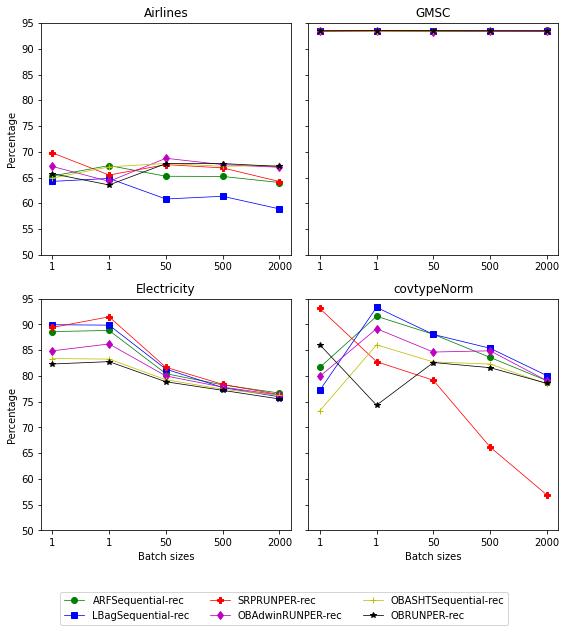

In [225]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)